In [1]:
import pandas as pd 
import baltic as bt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
from datetime import datetime

#set helvetica neue font
plt.rcParams["font.family"] = "Helvetica Neue"

Families in plot: 18 (Unknown: 0 )


/var/folders/px/rsw05wfs59z53lmzkhnhkq0c0000gn/T/ipykernel_24229/2374650433.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap("tab20", len(unique_fams))


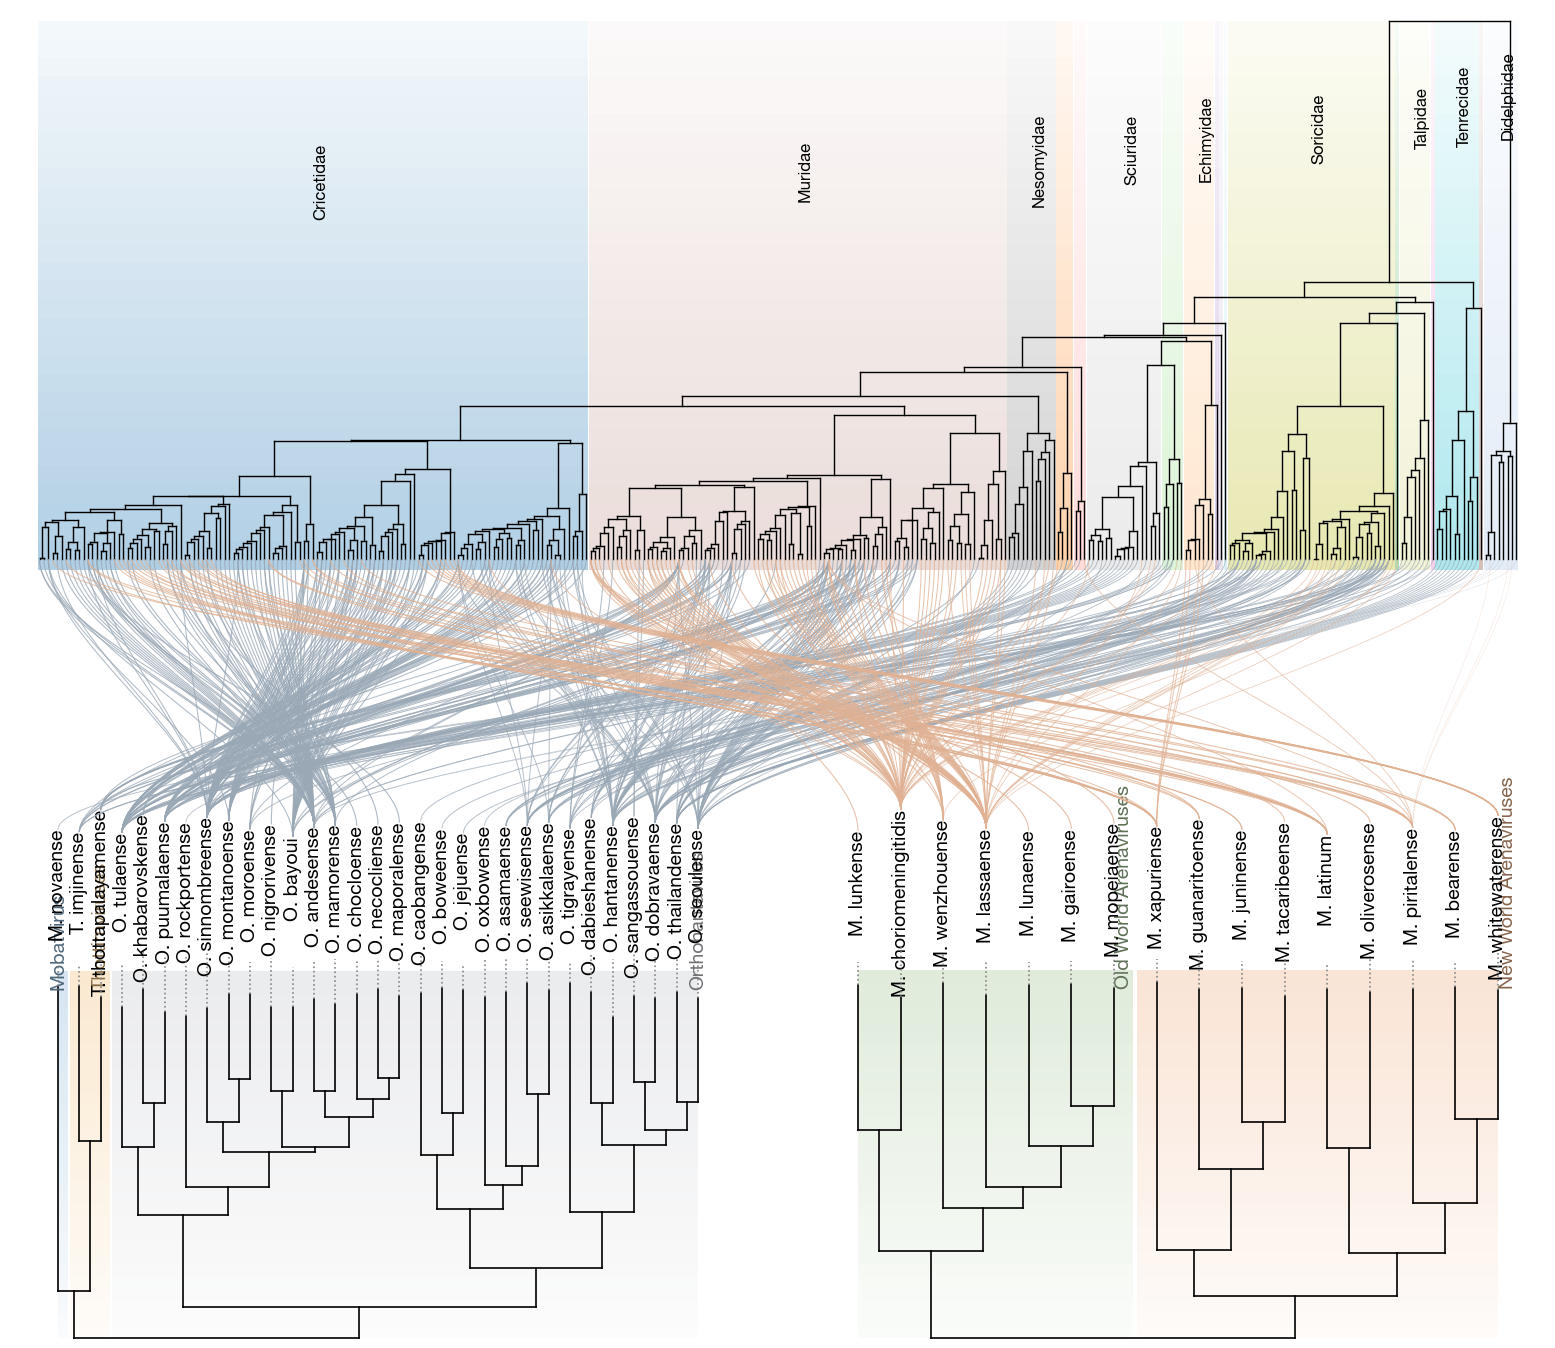

In [52]:
import pandas as pd
import baltic as bt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
from datetime import datetime

host_tree_file = "arha_upham_hosts_hanta_arena_linked.nwk"
virus_tree_file = "hanta_virus_tree_pruned.nwk"
residual_file = "cophylo_pairs_residuals.csv"

arena_virus_tree_file = "arena/arena_virus_tree_pruned.nwk"
arena_residual_file = "arena/cophylo_pairs_residuals.csv"

tax_path = "../../../../data/external/upham_taxonomy.csv"

# load trees
host_ll = bt.loadNewick(host_tree_file, absoluteTime=False)
host_ll.sortBranches()
host_ll.setAbsoluteTime(2025)
host_ll.drawTree()

virus_ll = bt.loadNewick(virus_tree_file, absoluteTime=False)
virus_ll.sortBranches()
virus_ll.setAbsoluteTime(2025)
virus_ll.drawTree()

# prepare host tree tiles
xs = [b.absoluteTime for b in host_ll.Objects if hasattr(b, "absoluteTime")]
ys = [b.y for b in host_ll.Objects if hasattr(b, "y")]

upham_tax = pd.read_csv(tax_path)
upham_tax["species"] = upham_tax["Species_Name"].str.replace("_", " ")
upham_tax["tip_clean"] = upham_tax["tiplabel"].str.replace("_", " ")

family_by_tip = dict(zip(upham_tax["tip_clean"], upham_tax["fam"]))
family_by_species = dict(zip(upham_tax["species"], upham_tax["fam"]))

leaves = [b for b in host_ll.Objects if getattr(b, "branchType", None) == "leaf"]
leaf_species = [b.name.replace("_", " ") for b in leaves]
leaf_fams = [family_by_tip.get(s) or family_by_species.get(s) or "Unknown" for s in leaf_species]

unique_fams = sorted(set(leaf_fams))
print("Families in plot:", len(unique_fams), "(Unknown:", leaf_fams.count("Unknown"), ")")

from matplotlib import cm
from matplotlib import colors as mcolors
from matplotlib.transforms import Affine2D
from matplotlib.patches import Rectangle

palette = cm.get_cmap("tab20", len(unique_fams))
family_colors = {fam: palette(i) for i, fam in enumerate(unique_fams)}

leaf_y = np.array([b.y for b in leaves])
step = np.median(np.diff(np.sort(leaf_y))) if len(leaf_y) > 1 else 1.0
band = step * 0.45

x_min, x_max = min(xs), max(xs)
span = x_max - x_min

fam_to_y = {}
for fam, y in zip(leaf_fams, leaf_y):
    fam_to_y.setdefault(fam, []).append(y)

n_slices = 30
min_alpha = 0.05
max_alpha = 0.35

# helper for label

def sentence_case(s):
    s = s.strip().lower()
    return s[:1].upper() + s[1:] if s else s


def norm_name(s):
    return ' '.join(str(s).strip().split())

# virus grouping for tiles
def hanta_group(name):
    n = norm_name(name).lower()
    if n.startswith('mobatvirus novaense') or n == 'm. novaense':
        return 'Mobatvirus'
    if 'thottimvirus imjinense' in n or 'thottimvirus thottapalayamense' in n or n.startswith('t. imjinense') or n.startswith('t. thotta'):
        return 'Thottimviruses'
    return 'Orthohantavirus'

old_world_arena = {
    'Mammarenavirus lunkense',
    'Mammarenavirus merinoense',
    'Mammarenavirus wenzhouense',
    'Mammarenavirus marientalense',
    'Mammarenavirus lassaense',
    'Mammarenavirus lunaense',
    'Mammarenavirus mopeiaense',
    'Mammarenavirus choriomeningitidis',
    'Mammarenavirus gairoense'
}

def arena_group(name):
    n = norm_name(name)
    if n in old_world_arena or n.replace('_',' ') in old_world_arena:
        return 'Old World Arenaviruses'
    return 'New World Arenaviruses'

# tile colors
hanta_tile_colors = {
    'Mobatvirus': '#8bb6d9',
    'Thottimviruses': '#f3c27b',
    'Orthohantavirus': '#c7c9cf',
}

arena_tile_colors = {
    'Old World Arenaviruses': '#a7c89a',
    'New World Arenaviruses': '#f0b48a',
}

# build figure with three subplots
fig = plt.figure(figsize=(16, 16))
ax_host = fig.add_axes([0.02, 0.58, 0.96, 0.35])
ax_virus = fig.add_axes([0.05, 0.10, 0.4, 0.30])
ax_arena = fig.add_axes([0.55, 0.10, 0.4, 0.30])

# rotate trees: host tips down, virus tips up
rot_host = Affine2D().rotate_deg(-90)
rot_virus = Affine2D().rotate_deg(90)

# plot host tree
host_ll.plotTree(ax=ax_host, x_attr=lambda k: k.absoluteTime, colour='k', linewidth=1)
for coll in ax_host.collections:
    coll.set_transform(rot_host + ax_host.transData)
    coll.set_clip_on(False)
    coll.set_zorder(2)

# host tiles
for fam, ys_fam in fam_to_y.items():
    y0 = max(min(ys_fam) - band, leaf_y.min() - band)
    y1 = min(max(ys_fam) + band, leaf_y.max() + band)
    color = family_colors[fam]
    for i in range(n_slices):
        frac = i / (n_slices - 1)
        x0 = x_max - frac * span
        width = span / n_slices * 1.035
        alpha = max_alpha - (max_alpha - min_alpha) * frac
        rect = Rectangle((x0, y0), width, y1 - y0,
                         facecolor=color, edgecolor="none", linewidth=0, alpha=alpha, antialiased=False)
        rect.set_transform(rot_host + ax_host.transData)
        ax_host.add_patch(rect)

# label families with vertical repel
h_rot = rot_host.transform(np.column_stack([xs, ys]))
label_y = h_rot[:, 1].min() + 0.7 * (h_rot[:, 1].max() - h_rot[:, 1].min())
labels = []
for fam, ys_fam in fam_to_y.items():
    if len(ys_fam) <= 5:
        continue

    y0 = max(min(ys_fam) - band, leaf_y.min() - band)
    y1 = min(max(ys_fam) + band, leaf_y.max() + band)
    mid = (y0 + y1) / 2
    x_text = mid
    labels.append((x_text, fam))

labels.sort(key=lambda t: t[0])
min_sep = (h_rot[:, 1].max() - h_rot[:, 1].min()) * 0.02
if min_sep == 0:
    min_sep = 1.0

y_texts = [label_y for _ in labels]
for i in range(1, len(y_texts)):
    if y_texts[i] - y_texts[i-1] < min_sep:
        y_texts[i] = y_texts[i-1] + min_sep

max_y = h_rot[:, 1].max() - min_sep
min_y = h_rot[:, 1].min() + min_sep
if y_texts and y_texts[-1] > max_y:
    shift = y_texts[-1] - max_y
    y_texts = [y - shift for y in y_texts]

y_texts = [min(max(y, min_y), max_y) for y in y_texts]

for (x_text, fam), y_text in zip(labels, y_texts):
    ax_host.text(x_text, y_text, sentence_case(fam),
                 rotation=90, va='center', ha='left', fontsize=12)

# host limits
pad_x = (h_rot[:, 0].max() - h_rot[:, 0].min()) * 0.02
pad_y = (h_rot[:, 1].max() - h_rot[:, 1].min()) * 0.02
ax_host.set_xlim(h_rot[:, 0].min() - pad_x, h_rot[:, 0].max() + pad_x)
ax_host.set_ylim(h_rot[:, 1].min() - pad_y, h_rot[:, 1].max() + pad_y)
ax_host.axis('off')

inv_fig = fig.transFigure.inverted()

# plot virus tree panel helper

def plot_virus_panel(ax, tree_file, label_offset=0.5, fontsize=10, tile_group_fn=None, tile_colors=None):
    v_ll = bt.loadNewick(tree_file, absoluteTime=False)
    v_ll.sortBranches()
    v_ll.setAbsoluteTime(2025)
    v_ll.drawTree()

    v_ll.plotTree(ax=ax, x_attr=lambda k: k.absoluteTime, colour='k', linewidth=1.2)
    for coll in ax.collections:
        coll.set_transform(rot_virus + ax.transData)
        coll.set_clip_on(False)

    v_xs = [b.absoluteTime for b in v_ll.Objects if hasattr(b, 'absoluteTime')]
    v_ys = [b.y for b in v_ll.Objects if hasattr(b, 'y')]
    v_rot = rot_virus.transform(np.column_stack([v_xs, v_ys]))
    ax.set_xlim(v_rot[:, 0].min(), v_rot[:, 0].max())
    ax.set_ylim(v_rot[:, 1].min(), v_rot[:, 1].max())
    ax.axis('off')

    v_leaves = [b for b in v_ll.Objects if getattr(b, "branchType", None) == "leaf"]
    v_tip = {norm_name(b.name.replace('_',' ')): (b.absoluteTime, b.y) for b in v_leaves}

    # optional virus tiles
    if tile_group_fn is not None and tile_colors is not None and v_leaves:
        v_leaf_names = list(v_tip.keys())
        v_leaf_y = np.array([b.y for b in v_leaves])
        v_groups = [tile_group_fn(n) for n in v_leaf_names]

        v_x_min, v_x_max = min(v_xs), max(v_xs)
        v_span = v_x_max - v_x_min
        v_step = np.median(np.diff(np.sort(v_leaf_y))) if len(v_leaf_y) > 1 else 1.0
        v_band = v_step * 0.45

        group_to_y = {}
        for g, y in zip(v_groups, v_leaf_y):
            group_to_y.setdefault(g, []).append(y)

        for g, ys_g in group_to_y.items():
            y0 = max(min(ys_g) - v_band, v_leaf_y.min() - v_band)
            y1 = min(max(ys_g) + v_band, v_leaf_y.max() + v_band)
            color = tile_colors.get(g, '#cccccc')
            for i in range(n_slices):
                frac = i / (n_slices - 1)
                x0 = v_x_max - frac * v_span
                width = v_span / n_slices * 1.035
                alpha = max_alpha - (max_alpha - min_alpha) * frac
                rect = Rectangle((x0, y0), width, y1 - y0,
                                 facecolor=color, edgecolor='none', linewidth=0, alpha=alpha, antialiased=False)
                rect.set_transform(rot_virus + ax.transData)
                ax.add_patch(rect)

        # tile labels (vertical), 25% darker than the tile color
        label_down_nudge = (v_rot[:, 1].max() - v_rot[:, 1].min()) * 0.02
        for g, ys_g in group_to_y.items():
            y0 = max(min(ys_g) - v_band, v_leaf_y.min() - v_band)
            y1 = min(max(ys_g) + v_band, v_leaf_y.max() + v_band)
            tile_color = tile_colors.get(g, '#cccccc')
            dark_color = tuple(max(0.0, c * 0.5625) for c in mcolors.to_rgb(tile_color))
            tx, ty = rot_virus.transform([[v_x_max, y0]])[0]
            ax.text(tx, ty - label_down_nudge, g, rotation=90, va='bottom', ha='right', fontsize=14, color=dark_color, alpha=1.0)

    # virus tip labels (Genus initial + species)
    v_labels = {}
    for name in v_tip.keys():
        parts = name.split()
        if len(parts) >= 2:
            v_labels[name] = f"{parts[0][0]}. {parts[1]}"
        else:
            v_labels[name] = name

    v_label_objs = []
    v_leaders = {}
    for name, (vx, vy) in v_tip.items():
        vxy = rot_virus.transform([[vx, vy]])[0]
        text_obj = ax.text(vxy[0], vxy[1] + label_offset, v_labels[name],
                     ha='center', va='bottom', fontsize=fontsize, rotation=90)
        text_obj.set_clip_on(False)
        v_label_objs.append((text_obj, name, vxy))

    # align label ends (top) across tips
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()
    inv_data = ax.transData.inverted()
    label_extents = []
    for text_obj, name, vxy in v_label_objs:
        bbox = text_obj.get_window_extent(renderer=renderer)
        (x0, y0), (x1, y1) = inv_data.transform(bbox.get_points())
        label_extents.append((text_obj, name, vxy, y1))

    max_y1 = max(y1 for _, _, _, y1 in label_extents)
    # expand ylim to include labels/leaders
    ax.set_ylim(v_rot[:, 1].min(), max(v_rot[:, 1].max(), max_y1 + 0.5))
    for text_obj, name, vxy, y1 in label_extents:
        dx, dy = 0.0, max_y1 - y1
        if dy != 0:
            x, y = text_obj.get_position()
            text_obj.set_position((x + dx, y + dy))
        # recompute label end after shift
        bbox = text_obj.get_window_extent(renderer=renderer)
        (x0, y0), (x1, y1_new) = inv_data.transform(bbox.get_points())
        # dotted leader from tip to label end
        line_obj, = ax.plot([vxy[0], vxy[0]], [vxy[1], y1_new],
                           linestyle=':', color='0.5', linewidth=1.2, alpha=0.95, zorder=100)
        line_obj.set_clip_on(False)
        v_leaders[norm_name(name)] = (vxy[0], y1_new)

    fig.canvas.draw()
    v_label_bboxes = {}
    v_label_end_fig = {}
    for text_obj, name, vxy in v_label_objs:
        bbox = text_obj.get_window_extent(renderer=renderer)
        bbox_fig = inv_fig.transform(bbox.get_points())
        v_label_bboxes[norm_name(name)] = bbox_fig
        # label end in fig coords (top of bbox); keep x aligned to tip x in fig coords
        tip_fig_x = inv_fig.transform(ax.transData.transform((vxy[0], vxy[1])))[0]
        v_label_end_fig[norm_name(name)] = (tip_fig_x, bbox_fig[1][1])

    return v_tip, v_label_bboxes, v_leaders, v_label_end_fig

# plot hanta virus panel
virus_tip, label_bboxes, virus_leaders, virus_label_end_fig = plot_virus_panel(ax_virus, virus_tree_file, label_offset=0.5, fontsize=14, tile_group_fn=hanta_group, tile_colors=hanta_tile_colors)

# plot arena virus panel
arena_tip, arena_label_bboxes, arena_leaders, arena_label_end_fig = plot_virus_panel(ax_arena, arena_virus_tree_file, label_offset=0.5, fontsize=14, tile_group_fn=arena_group, tile_colors=arena_tile_colors)

# links
from matplotlib.path import Path
import matplotlib.patches as mpatches

host_tip = {b.name.replace('_',' '): (b.absoluteTime, b.y) for b in leaves}

def data_to_fig(ax, x, y):
    return inv_fig.transform(ax.transData.transform((x, y)))

# link colors
hanta_link_color = "#9aa8b6"
arena_link_color = "#e0b193"

# hanta links
links = pd.read_csv(residual_file)

links['host'] = links['host'].map(norm_name)
links['virus'] = links['virus'].str.replace('_', ' ').map(norm_name)
links = links[links['host'].isin(host_tip) & links['virus'].isin(virus_tip)].copy()

r = links['residual'].values
r_min, r_max = r.min(), r.max()
if r_max == r_min:
    links['alpha'] = 0.55
    links['lwd'] = 0.55
else:
    inv = 1 - (r - r_min) / (r_max - r_min)
    links['alpha'] = 0.4 + 0.4 * inv
    links['lwd'] = 0.30 + 0.50 * inv

for _, row in links.iterrows():
    hx, hy = host_tip[row['host']]
    vx, vy = virus_tip[row['virus']]

    hxy = rot_host.transform([[hx, hy]])[0]
    vxy = rot_virus.transform([[vx, vy]])[0]

    p0 = data_to_fig(ax_host, hxy[0], hxy[1])
    p1 = data_to_fig(ax_virus, vxy[0], vxy[1])

    # offset anchors away from tip labels
    p0a = (p0[0], p0[1])
    p1a = (p1[0], p1[1])
    if row['virus'] in virus_label_end_fig:
        p1a = virus_label_end_fig[row['virus']]
    elif row['virus'] in virus_leaders:
        lx, ly = virus_leaders[row['virus']]
        p1a = data_to_fig(ax_virus, lx, ly)
    elif row['virus'] in label_bboxes:
        bbox = label_bboxes[row['virus']]
        p1a = (p1a[0], max(p1a[1], bbox[1][1] + 0.003))

    ctrl1 = (p0a[0], p0a[1] - 0.05)
    ctrl2 = (p1a[0], p1a[1] + 0.05)

    path = Path([p0a, ctrl1, ctrl2, p1a],
                [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    patch = mpatches.PathPatch(path, transform=fig.transFigure,
                               lw=row['lwd'], edgecolor=hanta_link_color, facecolor='none', alpha=row['alpha'])
    fig.patches.append(patch)

# arena links
arena_links = pd.read_csv(arena_residual_file)

arena_links['host'] = arena_links['host'].map(norm_name)
arena_links['virus'] = arena_links['virus'].str.replace('_', ' ').map(norm_name)
arena_links = arena_links[arena_links['host'].isin(host_tip) & arena_links['virus'].isin(arena_tip)].copy()

r = arena_links['residual'].values
r_min, r_max = r.min(), r.max()
if r_max == r_min:
    arena_links['alpha'] = 0.55
    arena_links['lwd'] = 0.55
else:
    inv = 1 - (r - r_min) / (r_max - r_min)
    arena_links['alpha'] = 0.4 + 0.4 * inv
    arena_links['lwd'] = 0.30 + 0.50 * inv

for _, row in arena_links.iterrows():
    hx, hy = host_tip[row['host']]
    vx, vy = arena_tip[row['virus']]

    hxy = rot_host.transform([[hx, hy]])[0]
    vxy = rot_virus.transform([[vx, vy]])[0]

    p0 = data_to_fig(ax_host, hxy[0], hxy[1])
    p1 = data_to_fig(ax_arena, vxy[0], vxy[1])

    # offset anchors away from tip labels
    p0a = (p0[0], p0[1])
    p1a = (p1[0], p1[1])
    if row['virus'] in arena_label_end_fig:
        p1a = arena_label_end_fig[row['virus']]
    elif row['virus'] in arena_leaders:
        lx, ly = arena_leaders[row['virus']]
        p1a = data_to_fig(ax_arena, lx, ly)
    elif row['virus'] in arena_label_bboxes:
        bbox = arena_label_bboxes[row['virus']]
        p1a = (p1a[0], max(p1a[1], bbox[1][1] + 0.003))

    ctrl1 = (p0a[0], p0a[1] - 0.05)
    ctrl2 = (p1a[0], p1a[1] + 0.05)

    path = Path([p0a, ctrl1, ctrl2, p1a],
                [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4])
    patch = mpatches.PathPatch(path, transform=fig.transFigure,
                               lw=row['lwd'], edgecolor=arena_link_color, facecolor='none', alpha=row['alpha'])
    fig.patches.append(patch)

plt.savefig("host_virus_cophylo_family_tiles.svg", dpi=600, bbox_inches='tight', pad_inches=0.1)
plt.show()
